[Dataset](https://www.kaggle.com/subhamjain/loan-prediction-based-on-customer-behavior?select=Training+Data.csv
)

# Upload Data

So first thing I need to do is download the dataset from Kaggle. Since it is now in my files, I want to access it from google colab, and upload it.

In [1]:
# Upload file to google colab from personal files

from google.colab import files
train_data = files.upload()

Saving Training Data.csv to Training Data.csv


# Wrangle Data

Now that I uploaded the file, I am going to want to make a function that wrangles it. After cleaning the dataset, I condensed all the changes I made to it into a single 'wrangle' function. These steps include: reading the csv_file, resetting the index, dropping unnecessary rows, encoding applicable features, renaming columns, dropping high-cardinality categorical features, and rebalancing the data.

In [2]:
# Make a wrangling function that includes steps

def wrangle(file):
  # Read file
  import pandas as pd
  df = pd.read_csv(file)

  # Set index as 'Id'
  df = df.set_index('Id')
  
  # Drop 'norent_or_noown' values
  badvals = df.loc[df['House_Ownership'] == 'norent_noown']
  bad_indx = badvals.index
  df.drop(labels=bad_indx, inplace=True)

  # Encode applicable columns
  df['Married/Single'] = df['Married/Single'].apply(lambda value: 1 if value=='married' else 0)
  df['House_Ownership'] = df['House_Ownership'].apply(lambda value: 1 if value=='owned' else 0)
  df['Car_Ownership'] = df['Car_Ownership'].apply(lambda value: 1 if value=='yes' else 0)

  # Rename columns
  df = df.rename(columns={'Experience' : 'Total_Professional_Experience_Years',
                        'Married/Single' : 'Married',
                        'CITY' : 'City',
                        'STATE' : 'State',
                        'CURRENT_JOB_YRS' : 'Current_Job_Years',
                        'CURRENT_HOUSE_YRS' : 'Current_House_Years'})
  
  # Drop HCC's
  df = df.drop(columns=['Profession', 'City', 'State'])

  # Rebalance data
  balanced = (df.loc[df['Risk_Flag'] == 0]).sample(frac=.9).index
  df = df.drop(labels=balanced)

  return df

After making the wrangle function, I am going to use it to wrangle the 'Training Data.csv' file.*italicized text*

In [3]:
# Wrangle file

df = wrangle('Training Data.csv')

Now to check the dataframe head...

In [4]:
# Check dataframe head

df.head()

,Income,Age,Total_Professional_Experience_Years,Married,House_Ownership,Car_Ownership,Current_Job_Years,Current_House_Years,Risk_Flag
Id,,,,,,,,,
4,6256451,41,2,0,0,1,2,12,1
5,5768871,47,11,0,0,0,3,14,1
8,1706172,33,2,0,0,0,2,14,0
15,9420838,48,6,0,0,0,6,10,1
18,3666346,56,12,0,0,0,12,11,1


# Split Data

After wrangling the data, it's time to split it! Here I split it into my feature matrix and target vector.

In [5]:
# Split data

X = df.drop(columns='Risk_Flag')
y = df['Risk_Flag']

Then I have to split the feature matrix and target vector into training sets (for training the model), validation sets (to tune the model), and test sets (to test the model).

In [6]:
# Import train_test_split to split data further into training, validation, and test sets

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.34, random_state=42)

# Establish Baseline

It is time to establish a baseline! Because this is a classification prediction, I will set the baseline as the mode in the 'y_train' vector.

In [7]:
# Establish baseline for classification problem

baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5851737302469434


# Build Models

Before building the models, I am going to import necessary tools...

In [8]:
# Import sklearn tools

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

###Linear Model

Now to make my logistic regression model... I am going to make a pipeline and add two steps: the 'StandardScaler' for scaling the features and the 'LogisticRegression' linear model.

In [9]:
# Make logistic regression model

model1 = make_pipeline(StandardScaler(),
                       LogisticRegression(random_state=42))

Time to train!

In [10]:
# Fit logistic regression model

model1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

### Tree-Based Model

This time I am going to make my tree-based model... I am going to make a pipeline and add two steps: the 'StandardScaler' for scaling the features and the 'RandomForestClassifier' tree-based model.

In [11]:
# Make random forest model

model2 = make_pipeline(StandardScaler(),
                       RandomForestClassifier(max_depth=20, random_state=42, n_jobs=-1))

Fitting training data...

In [12]:
# Fit random forest model

model2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

# Check Metrics

Cool, now what? Now we check the metrics of each model...

In [13]:
# Import metric tools

from sklearn.metrics import accuracy_score, classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve

### Linear Model

Accuracy

Here I find the accuracy scores of the logistic regression model, it's pretty bad!

In [14]:
# Print training and validation accuracy scores for logistic regression model

print('Training Accuracy (LOGR):', model1.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model1.score(X_val, y_val))

Training Accuracy (LOGR): 0.5893297250277871
Validation Accuracy (LOGR): 0.5906184409625617


Precision, Recall, F1

Here I print out the classification report and confusion matrix for the logistic regression model, which shows me visually the precision and recall scores, as well how the model predicted values versus the true values.

              precision    recall  f1-score   support

           0       0.56      0.06      0.11      8501
           1       0.59      0.97      0.73     11986

    accuracy                           0.59     20487
   macro avg       0.58      0.51      0.42     20487
weighted avg       0.58      0.59      0.47     20487



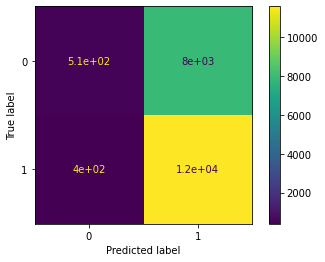

In [15]:
# Print classification report and confusion matrix for logistic regression model

print(classification_report(y_val, model1.predict(X_val)))
plot_confusion_matrix(model1, X_val, y_val);

ROC Curve

This step prints out the ROC curve for the logistic regression model. This displays the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

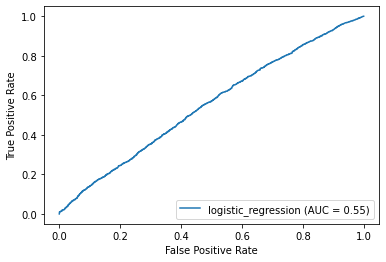

In [16]:
# Print ROC curve for logistic regression model

roc1 = plot_roc_curve(model1,
               X_val,
               y_val,
               name='logistic_regression');

### Tree-Based Model

Accuracy

Here I find the accuracy scores of the tree-based model, it's way better than the baseline as well as the logistic regression model!

In [17]:
# Print training and validation accuracy scores for random forest model

print('Training Accuracy (RF):', model2.score(X_train, y_train))
print('Validation Accuracy (RF):', model2.score(X_val, y_val))

Training Accuracy (RF): 0.9619678152032088
Validation Accuracy (RF): 0.8252062283399229


Precision, Recall, F1

Here I print out the classification report and confusion matrix for the random forest model, which shows me visually the precision and recall scores, as well how the model predicted values versus the true values.

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      8501
           1       0.85      0.85      0.85     11986

    accuracy                           0.83     20487
   macro avg       0.82      0.82      0.82     20487
weighted avg       0.83      0.83      0.83     20487



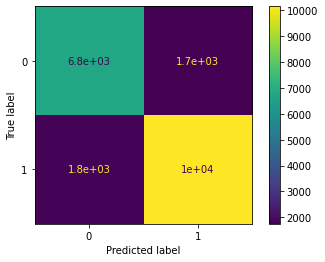

In [18]:
# Print classification report and confusion matrix for random forest model

print(classification_report(y_val, model2.predict(X_val)))
plot_confusion_matrix(model2, X_val, y_val);

ROC Curve

This step prints out the ROC curve for random forest model. This displays the diagnostic ability of a binary classifier system as its discrimination threshold is varied. Way better!

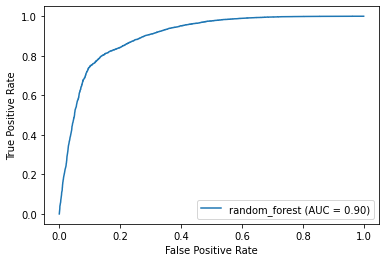

In [19]:
# Print ROC curve for random forest model

roc2 = plot_roc_curve(model2,
                   X_val,
                   y_val,
                   name='random_forest');

We see that Model 2 (the random forest model) is way better. Let's use this model to visualize more information and ultimately use it for the test set!

# Checking Feature Importances

First step here is to import pandas.

In [20]:
# Import pandas

import pandas as pd

This next step is where it gets clear. I am going to make a horizontal bar graph to show the highest gini importances of the top ten features.

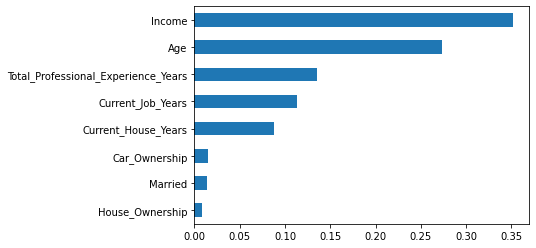

In [21]:
# Graphing feature importances of random forest model

importances = model2.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

Installing pdpbox for another visualization...

In [22]:
# Installing pdp tools

!pip install pdpbox;
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

     |████████████████████████████████| 34.0 MB 42 kB/s 
     |████████████████████████████████| 13.1 MB 6.7 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=a73d82ac4d92bef1ea7137d7cc99d5fcec02191374c4b5e7fcc2e6a823fd523d
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


This step will include choosing the feature with the highest gini importance, 'Income' and graphing it to show the effect and relationship it has on the predicted outcome of the random forest model.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


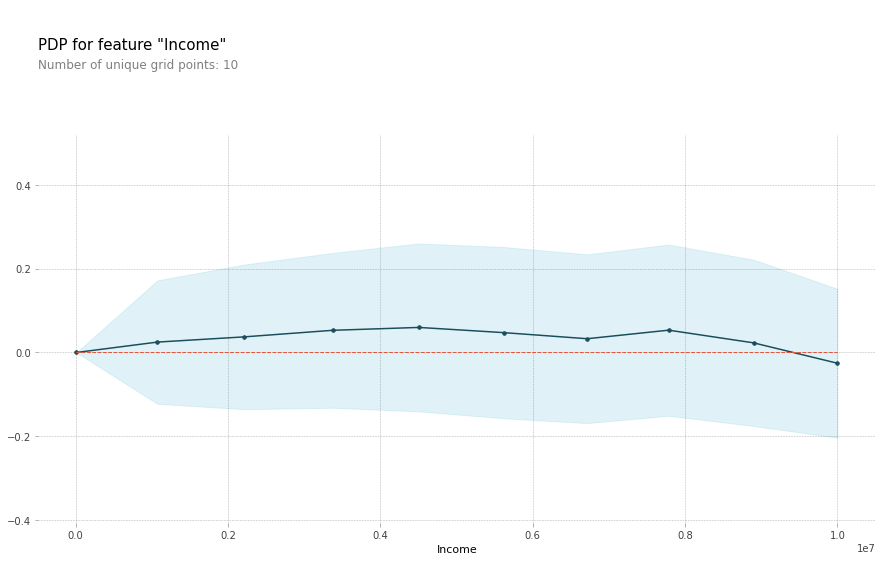

In [23]:
# Plotting pdp graph

feature = 'Income'
isolate = pdp_isolate(model2,
                      dataset=X_val,
                      model_features=X_val.columns,
                      feature=feature)
pdp_plot(isolate, feature_name=feature);

We can see that the relationship is more or less linear.

# Test Set

Finally, the time has come to see how well the random forest model works on the data it has not seen!

In [24]:
# Apply model to test set

test_acc = accuracy_score(y_test, model2.predict(X_test))
print('Test Accuracy Score:', test_acc)

Test Accuracy Score: 0.8275535342050407


As we can see, this is a pretty solid accuracy rate! We can deduce that our model can correctly classify about 83% of unseen data! 